# Natural Gas Consumption Prognosis in a Chloro-Soda Industry

This script performs a time series study to forecast on day ahead the consumption of natural gas in a Chloro-Soda Industry. The data goes from 2012 to 2018. Our intention is to use 2012-2017 values to train the model and 2018 to test the model.

## Data Acquisition and Manipulation

In [2]:
#Importing the packages used in this script
library(dplyr)
library(urca)
library(forecast)
library(tidyverse)
library(tseries)
library(imputeTS)
library(plotly)
library(pracma)
library(neuralnet)
library(e1071)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘imputeTS’

The following object is masked from ‘package:tseries’:

    na.remove


Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout


Attaching package: ‘neuralnet’

The following object is masked from ‘package:dplyr’:

    compute



In [3]:
file1 = "gas_consumption_030712-311217.csv" # This csv file has date and consumption of natural gas in m3/day 
# from 03/07/2012 to 31/12/2017

time_series_df1<- read.csv2(file1, sep = ";",header = FALSE,
                            na.strings = c("0", "-1", "NA", "-")) # reading the data. Here We assume a missing value to be every
# 0, -1, - and NA string in the file

time_series_df1 <- time_series_df1 %>% select(c(1,2))

time_series_df1 <- time_series_df1 %>% arrange(V1)
#Formating the dataframe

# Convert the 1st column to date and the 2nd to numeric

time_series_df1$V1 <- time_series_df1$V1 %>% as.Date() 
time_series_df1$V2 <- as.character(time_series_df1$V2) %>%  as.numeric()

## Exploratory Data Analysis

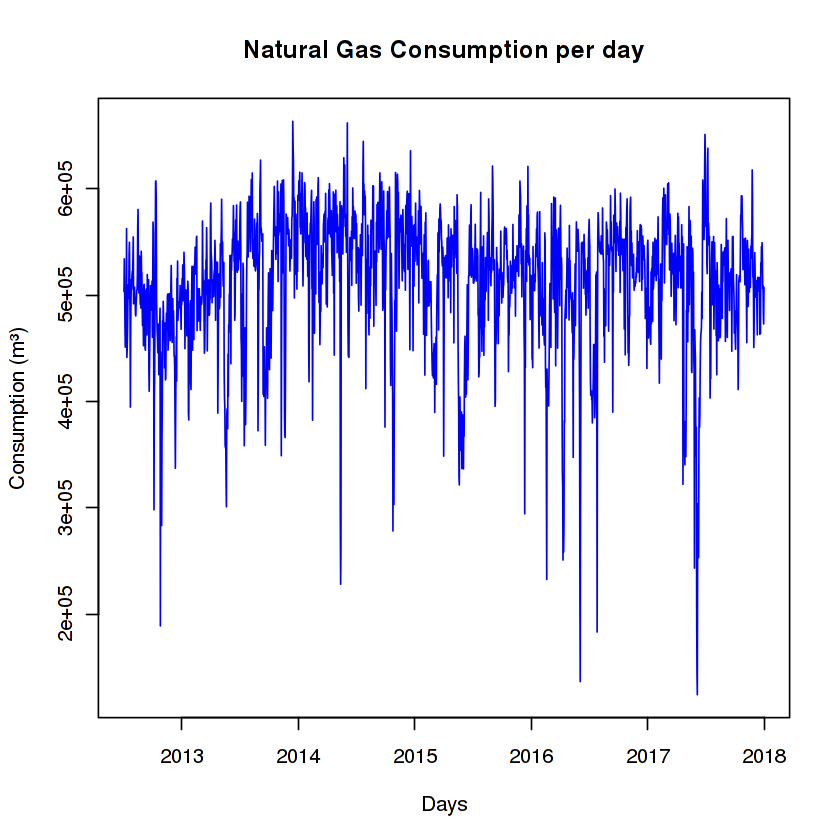

In [4]:
plot(time_series_df1, type = "l", col = "blue", xlab = "Days",
     ylab = "Consumption (m³)", main = "Natural Gas Consumption per day")

In [5]:
file2 = "gas_consumption_170318-301118.csv" #This csv file has date and consumption of natural gas in m3/day 
# from 17/03/2018 to 30/11/2018
time_series_df2<- read.csv2(file2, sep = ";",header = FALSE,
                            na.strings = c("0", "-1", "NA", "-"))  # reading the data. Here We assume a missing value to be every
# 0, -1, - and NA string in the file

time_series_df2 <- time_series_df2 %>% select(c(1,2))

time_series_df2 <- time_series_df2 %>% arrange(V1)
#FOrmating the dataframe

# Convert the 1st column to date and the 2nd to numeric
time_series_df2$V1 <- time_series_df2$V1 %>% as.Date()
time_series_df2$V2 <- as.character(time_series_df2$V2) %>%  as.numeric()


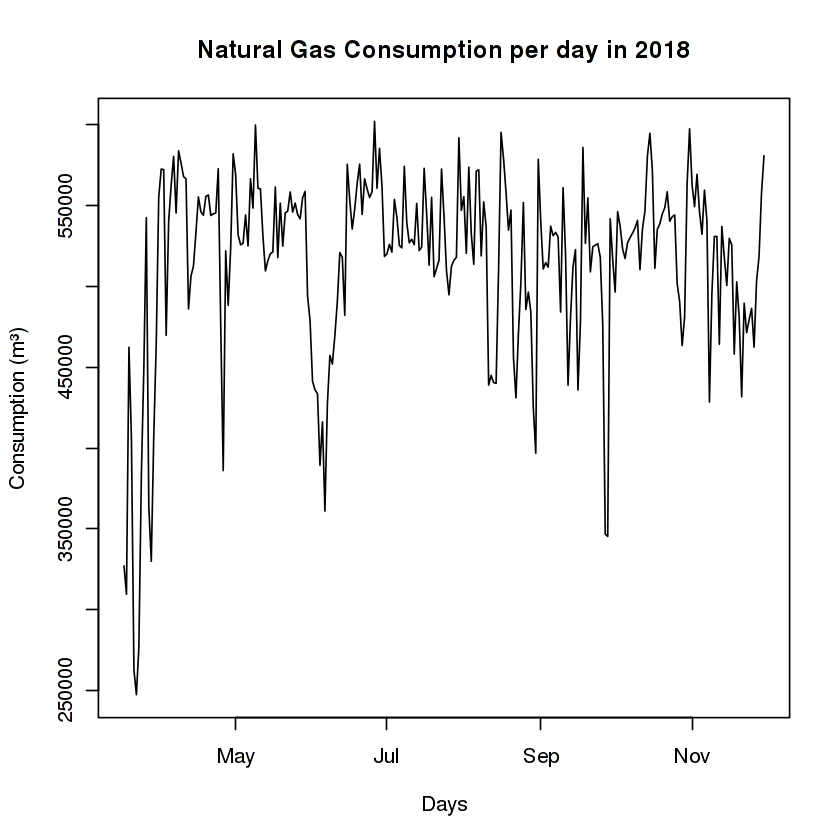

In [6]:
plot(time_series_df2, type = "l", col = "black", xlab = "Days",
     ylab = "Consumption (m³)", main = "Natural Gas Consumption per day in 2018")

In [7]:
#Seeing if there is some NA values in the time series

time_series_df1$V2 %>% statsNA()
time_series_df2$V2 %>% statsNA() #No one missing values in the data


[1] "Length of time series:"
[1] 2007
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 0
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0%"
[1] "-------------------------"
[1] "No NAs in the time Series."


[1] "No NAs"

[1] "Length of time series:"
[1] 259
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 0
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0%"
[1] "-------------------------"
[1] "No NAs in the time Series."


[1] "No NAs"

In [8]:
# Creating a time series from the dataframes

ts1 <- ts(time_series_df1$V2, frequency = 365, start=c(2012,184), end=c(2017,365))
ts2 <- ts(time_series_df2$V2, frequency = 365, start = c(2018, 76), end = c(2018,334))

In [9]:

# Checking stationarity
# Let's check the stationarity for the entiry dataset. So, let's combine the two datasets firstly
total_ts <- c(ts1,ts2)

In [10]:
# Let's create a function to check stationarity of a time series
checkStat <- function (s) {
  
  # This function applies 2 methods to check the stationarity of a time series: KPSS test and ADF test.
  # If p > 0.55 in kpss test, we reject the null hp0 and we think this series as non-stationary. If p <0.55 we assume the series is trend-st
  # If p < 0.55 in adf, we reject the null hp0 and we think this series as stationary. If p > 0.55 It is non-stat
  # Use also adf.test
  
  #Case 1: Both tests conclude that the series is not stationary -> series is not stationary
  #Case 2: Both tests conclude that the series is stationary -> series is stationary
  #Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
  #Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary
  
  library(urca)
  library(forecast)
  library(tseries)
  x <- ur.kpss(s)
  print(x) 
  adf.test(s)
  
}

total_stat_test <-checkStat(total_ts)
total_stat_test


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.3735 



Warning message in adf.test(s):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  s
Dickey-Fuller = -10.057, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


In [11]:
# From the results (concerning the four cases presented inside the scope of the function checkStat),
#We assume the time series to be stationary

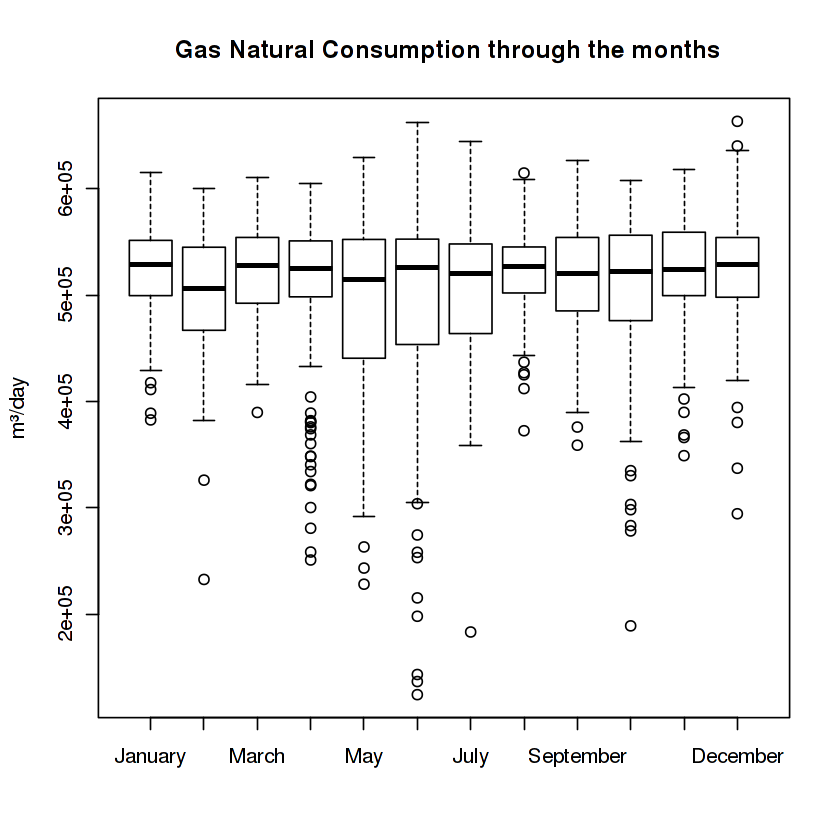

In [12]:
# Let's plot a boxplot to see how the consumption varies according to the months

monthColumn=ordered(months(time_series_df1$V1), levels= c("January", "February", 
                                               "March", "April", "May", "June", "July", "August", "September", 
                                               "October", "November", "December")) 

bp_gas_pvccloro <-  boxplot(time_series_df1$V2 ~ monthColumn, ylab = "m³/day", main = " Gas Natural Consumption through the months") 

In [13]:
# Apparently, the month is not an important variable in the gas consumption. 

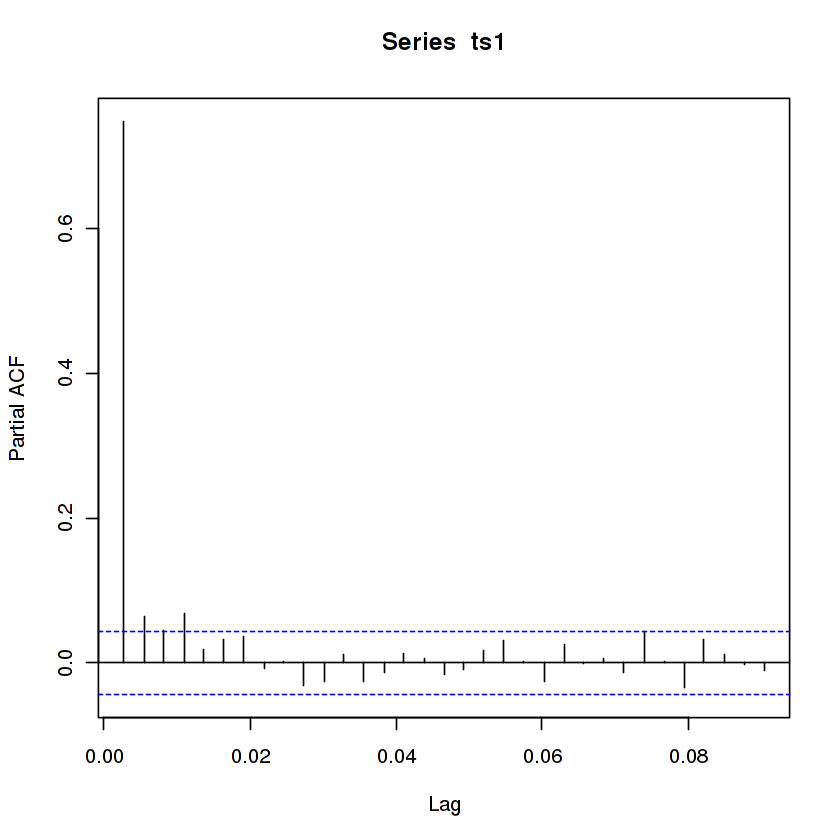

In [14]:
# Now We should analyse how the time series is correlated with itself
partial_correlation_function <- pacf(ts1) # Partial Autocorrelation function

# We see that the time series has a correlation of 4th order with itself. This result will be considered in the model.

$$y(t+1)=f(y(t),y(t−1),y(t−2),y(t−n))$$

In [14]:
# In order to forecast the consumption, We'll consider the prediction one step ahead as a function of the previous values of 
# consumption as It's shown above. In our case, specifically, the consumption is correlated with Its 4 previous values.
# Let's now create a data frame in which We will have 5 columns: 1 column We Will have the values one step ahead and in 
# the other 4 will be the 4 previous values. This way We will create our training set and our test set.

## Modelling

In [15]:
ARnet <- function(s, lag){

  # This function takes a time series s and a lag value.
  # It returns a data frame containing lag+1 columns, one being the target and the other the  
  # values of the series lagged in time
  lagged_data <- data.frame(s)
 
  for (i in 1:lag){
    
    aux <- lag(s, i)
    
    lagged_data <- cbind(lagged_data, aux)
    
  }
  
  
  
  lagged_data <- lagged_data[-(1:lag),]
  
  return(lagged_data)
    
  }

In [16]:
XY <- ARnet(total_ts,4) # Creating the dataset 
colnames(XY) <- c("Y(t+1)", "Y(t)", "Y(t-1)", "Y(t-2)", "Y(t-3)") # Renaming the columns

In [17]:
head(XY)

,Y(t+1),Y(t),Y(t-1),Y(t-2),Y(t-3)
5,451125.2,471242.1,508852.0,534062.6,503277.6
6,463672.7,451125.2,471242.1,508852.0,534062.6
7,465267.6,463672.7,451125.2,471242.1,508852.0
8,464107.3,465267.6,463672.7,451125.2,471242.1
9,562464.0,464107.3,465267.6,463672.7,451125.2
10,441479.8,562464.0,464107.3,465267.6,463672.7


In [18]:
# Let's now split the data into training and test sets

xtrain <- XY[1:2007,2:5] # tuples used in the training phase
xtest <- XY[2008:nrow(XY),2:5] # tuples used to make new predictions
ytrain <- XY[1:2007, 1] # Real values used as targets in the training phase
ytest <- XY[2008:nrow(XY),1] # Real values to compare the values predicteds


In [55]:
XY_train<-cbind(xtrain,ytrain)
colnames(XY_train) <- c("V", "V1", "V2", "V3", "Y")
head(XY_train)
colnames(xtest) <- c("V", "V1", "V2", "V3")

,V,V1,V2,V3,Y
5,471242.10,508852.05,534062.55,503277.60,451125.15
6,451125.15,471242.10,508852.05,534062.55,463672.65
7,463672.65,451125.15,471242.10,508852.05,465267.60
8,465267.60,463672.65,451125.15,471242.10,464107.35
9,464107.35,465267.60,463672.65,451125.15,562464.00
10,562464.00,464107.35,465267.60,463672.65,441479.85


In [97]:
# Let's use a support vector machine with a polynomial kernel to tackle this problem
svm_model <- svm(Y ~ V + V1 + V2 + V3, data = XY_train, type = 'eps-regression', kernel = 'polynomial', degree = 1.85)


In [98]:
svm_predicted <- predict(svm_model, xtest)

## Model Evaluation

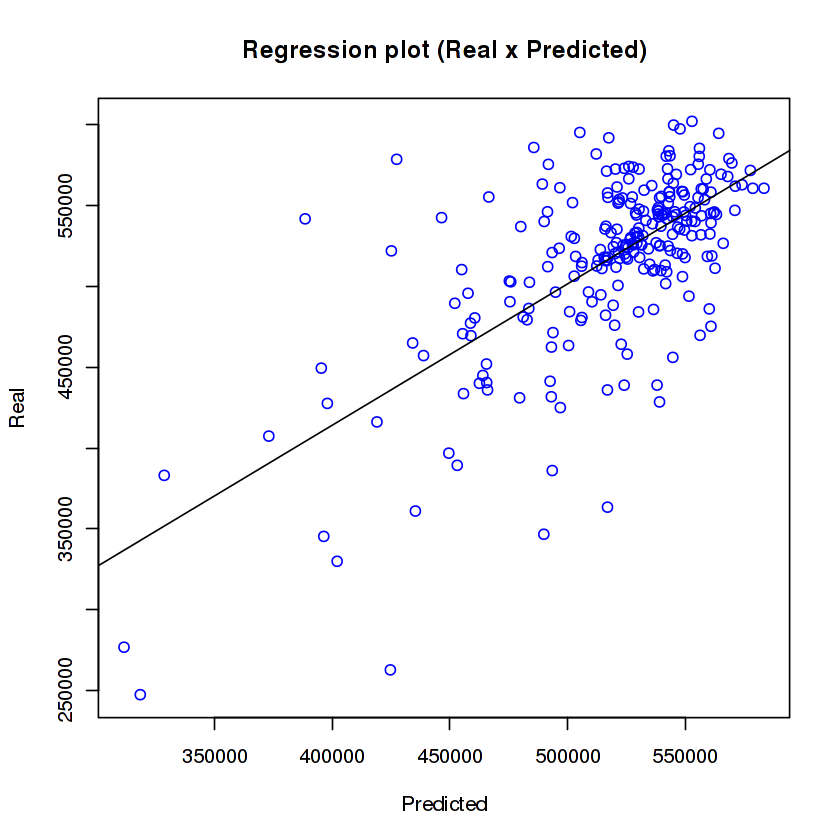

In [99]:
plot(svm_predicted, ytest, col = "blue",xlab = "Predicted", ylab = "Real", main = "Regression plot (Real x Predicted)")
abline(lm(ytest ~ svm_predicted))

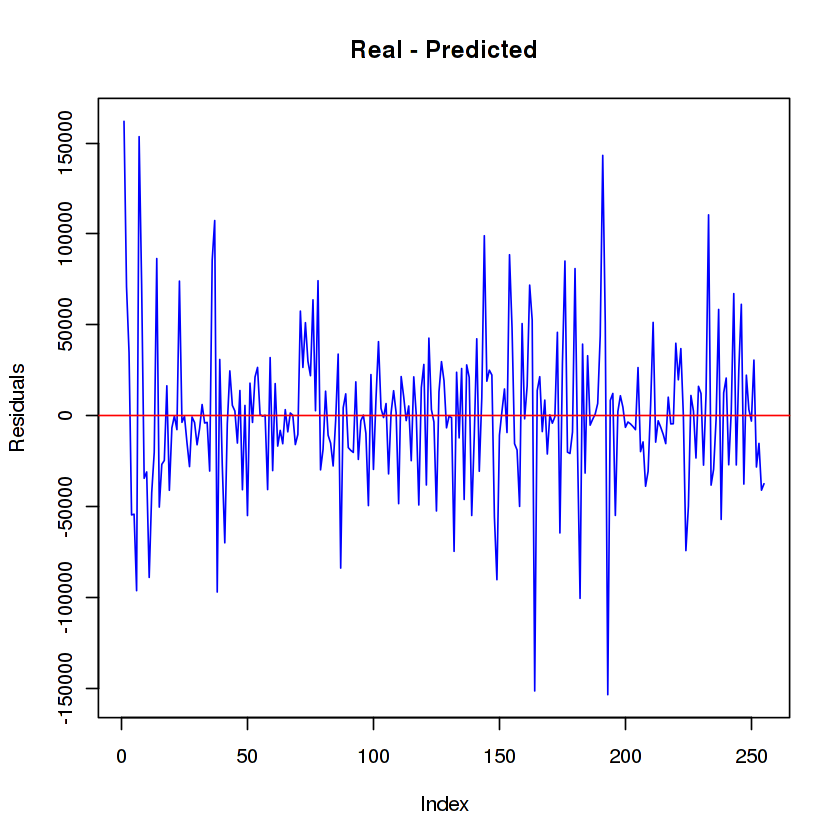

In [100]:
# Deviation plot
plot(svm_predicted -  ytest, type = "l", col = "blue", xlab = "Index", ylab = "Residuals", main = "Real - Predicted")
abline(h = 0, col = "red")

In [101]:
performance <- function (Y, y) {
  
  #This functions takes Y, which are the real values and y which are the predicted values
  RMSE <-  (sum((Y - y)^2) / length(y)) ^ 0.5  #This is the Root Mean Squared Error
  MAPE <- sum(abs((Y-y)/Y))*(100)/length(Y) # This is the Mean Absolute Percentage Error
  SSE <- sum((Y - y)^2) # THis is the Sum of Squared Errors
  
  R <- cor(Y,y) #The same pearson's correlation
 
 return(data.frame(RMSE = RMSE,MAPE  =MAPE,SSE = SSE, R = R))

}

In [102]:

errors_neural_model <- performance(ytest,svm_predicted)
errors_neural_model

RMSE,MAPE,SSE,R
41743.08802,6.051582722,444333776324,0.6782024734


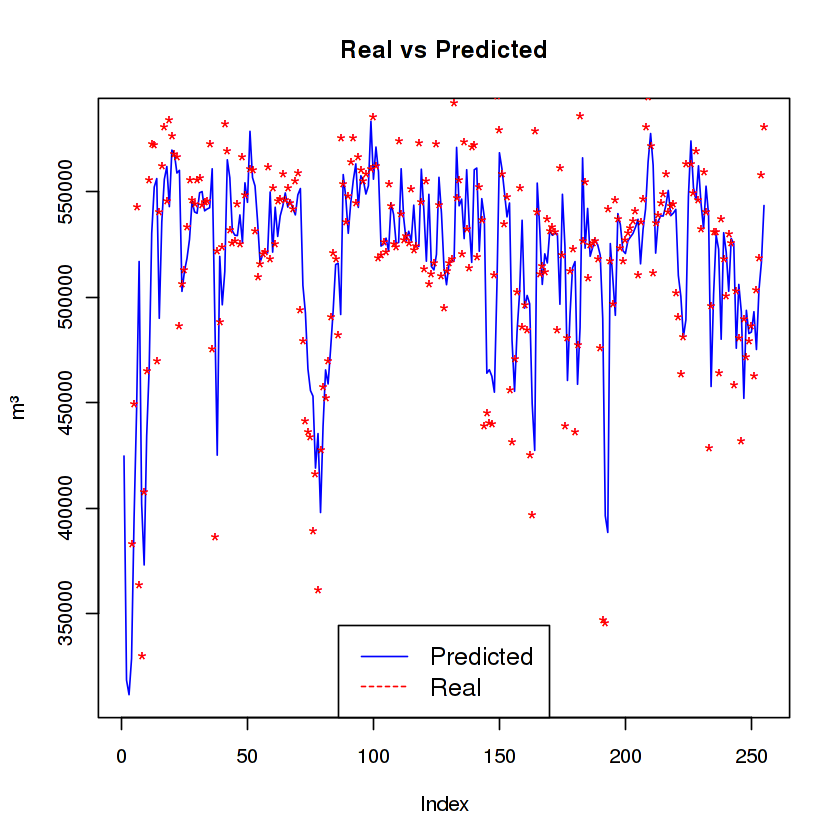

In [118]:
plot(svm_predicted, type = "l", col = "blue", main = "Real vs Predicted", xlab = "Index", ylab  = "m³")
points(ytest, pch = "*",cex = 1.3, col = "red")
legend("bottom", legend=c("Predicted", "Real"),
       col=c("blue", "red"), lty=1:6, cex=1.2)

In [1]:
# The results were very promising. Of course It lacks a more optmized algorithm. This could be accomplished with a 
# genetic algorithm, for example, having in the chromossomes the type of kernel and other parameters treated as default in this analysis
# Furthermore, It's posible to use a recurrent neural network, either Elman's or Jordan's and even a LSTM network to accomplhish
# this task, once they have shown great results concerning time series forecasting problems
# Last but not least, one specific techinque could improve our results: Discrete Wavelet Transform. Through this technique, We
# Could extract information (low and high frequencies) from the time series and use them as input for the support vector machine